Загружаем датасет.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


Подключаем гугл диск для удобного сохранения моделей.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Читаем датасет, выводим первые строки.

In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['test.csv']))
df.head()

,Unnamed: 0,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,target
0,0,2736.0,1115.0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,1,3258.0,1177.0,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0
2,2,2104.0,2040.0,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0,1.0
3,3,5435.0,289.0,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0,0.0
4,4,6899.0,1822.0,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0,0.0


Обозрение датасета. Видим первую колонку - id. Остальные данные числовые с плавающей точкой. Нулевых/пропущенных значений нет. Целевая колонка - target. Из 1 и 0 - задача бинарной классификации.
Выбираем метрики Accuracy и f-мера.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   feature_0   10000 non-null  float64
 2   feature_1   10000 non-null  float64
 3   feature_2   10000 non-null  float64
 4   feature_3   10000 non-null  float64
 5   feature_4   10000 non-null  float64
 6   feature_5   10000 non-null  float64
 7   feature_6   10000 non-null  float64
 8   feature_7   10000 non-null  float64
 9   feature_8   10000 non-null  float64
 10  feature_9   10000 non-null  float64
 11  feature_10  10000 non-null  float64
 12  feature_11  10000 non-null  float64
 13  target      10000 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 1.1 MB


Проверяем наличие дубликатов в датафрейме.

In [ ]:
df.duplicated().unique()

array([False])

Уберём колонку с индексами.

In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)

Смотрим корреляции между независимыми переменными. Корреляций не наблюдаем.

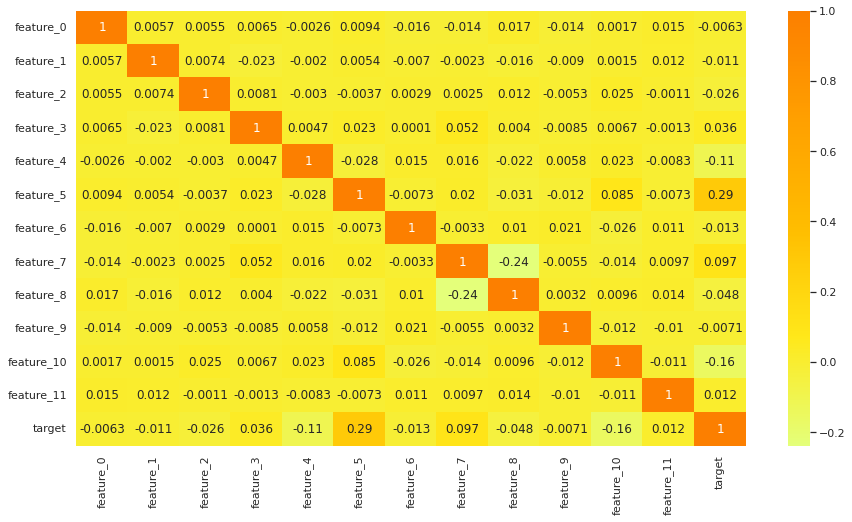

In [ ]:

import seaborn as sns 
sns.set(rc = {'figure.figsize':(15,8)})
corr = df.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True)

Проверим независмые переменные на выбросы. Для этого можно построить графики-боксплоты каждой колоник. Колонки с индексами 5 и 8 в списке колонок имеют выбросы.

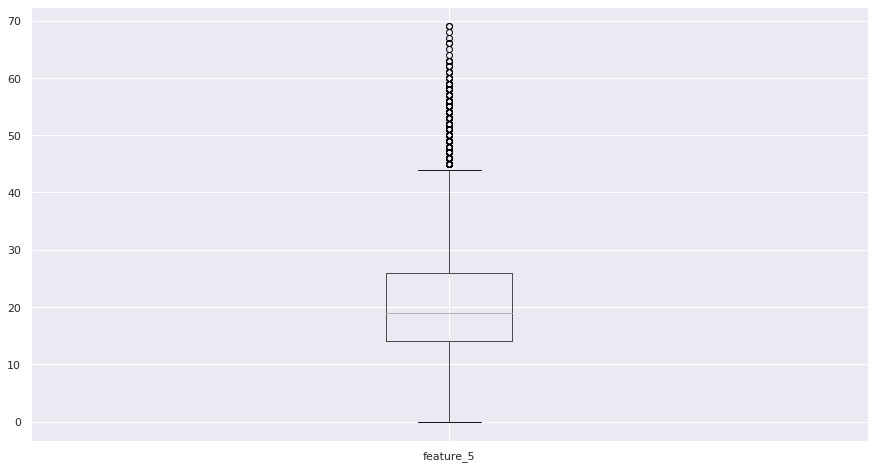

In [ ]:
df.boxplot(df.columns[5])

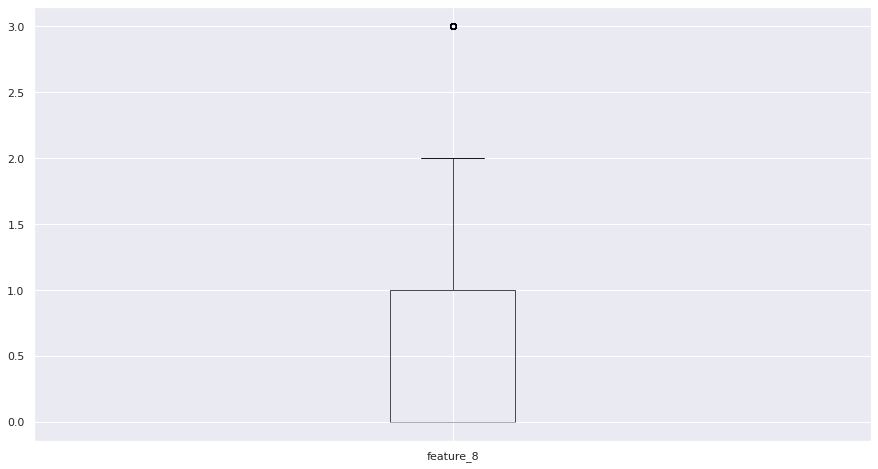

In [ ]:
df.boxplot(df.columns[8])

Уберём строки из датафрейма, значения которых в колонках с индексами 6 и 9 больше 75% квантиля. Значение определим по графикам боксплот.
Выведем форму датафреймов после удаления выбросов.

In [ ]:
col5, col8 = df.columns[5], df.columns[8] 
df_outl = df[df[col5] < 42]
df_outl.shape

(9474, 13)

In [ ]:
df_outl2 = df_outl[df_outl[col8] < 2.5]
df_outl2.shape

(9418, 13)

Снова построим боксплоты колонок, выбросы в которых убрали. Чтобы убедиться в их отсутствии.

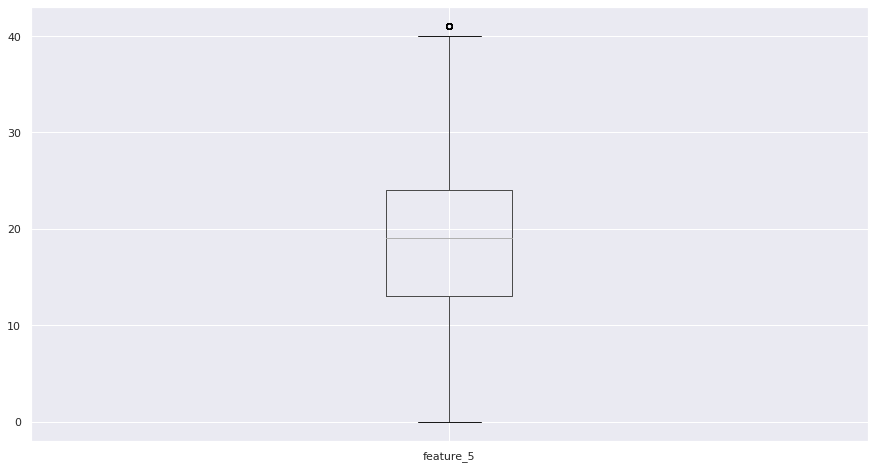

In [ ]:
df_outl2.boxplot(df.columns[5])

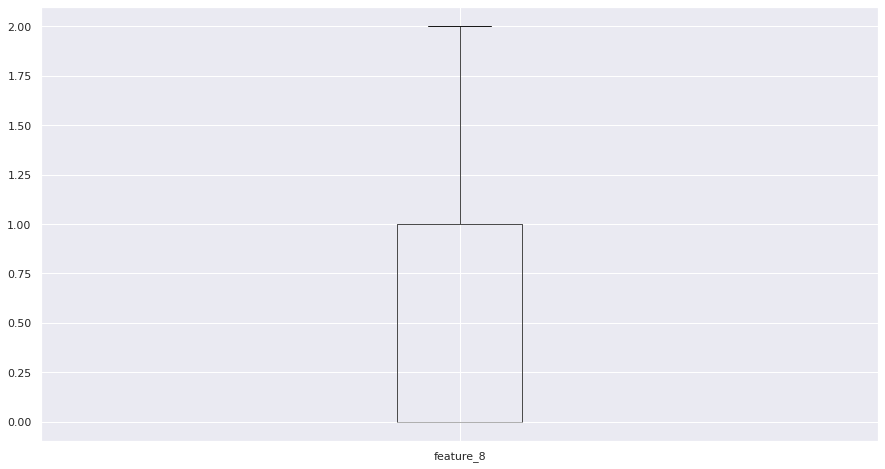

In [ ]:
df_outl2.boxplot(df.columns[8])

Переопределим значение датафрейма, чтобы не запутаться в версиях.

In [ ]:
df = df_outl2

In [ ]:
df.shape

(9418, 13)

Попробуем нормализовать данные в диапазоне от 0 до 1. Перезапишем датафрейм

In [ ]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [ ]:
normalized_df
df = normalized_df

Построим графики фичей, чтобы посмотреть на нормальность распределения.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb75c940850>,
      dtype=object)

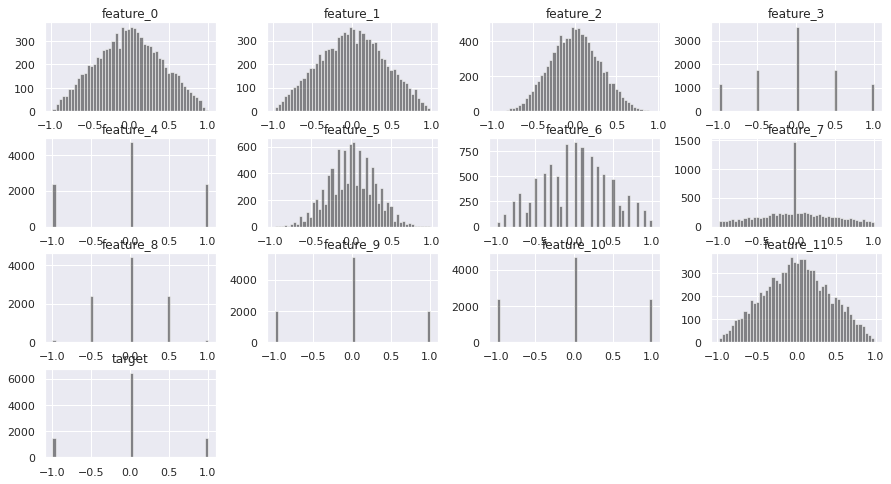

In [ ]:
df.diff().hist(color="k", alpha=0.5, bins=50)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Разделим данные на признаки и целевую колонку. Выведем целевую 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X = df.drop(['target'], axis = 1) 
y = df.target         
y       

0       1.0
1       0.0
2       1.0
3       0.0
4       0.0
       ... 
9995    0.0
9996    0.0
9997    1.0
9998    1.0
9999    0.0
Name: target, Length: 9418, dtype: float64

Разделим данные на тренировочные и тестовые. В параметрах обучения будет встроена кросс-валидация, поэтому данные для валидации не оставляем. Если нужны данные для валидации, то можно тем же методом разделить данные X, y на X_val, y_val, X_train, y_train, затем ещё раз одну из выборок на X_test, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

-------------------------------------------------------------------------------

Задаем экземпляр класса Рандомный Лес. Задаём параметры сетки (число эстиматоров, глубину дерева, минимальное число объектов в узле для расщепления, минимальное число объектов в листьях. Критерий сходимости - кросс-энтропия.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=34, n_jobs=-1)
parametrs = {'n_estimators': range(10, 101, 10), 'criterion': ['entropy'], 'max_depth': range(1, 13, 2), 'min_samples_split': range(2, 10, 2), 'min_samples_leaf': range(1, 8)}

Фитим данные в модель. Задаём количество фолдов кросс-валидации, включаем многопоточность.

In [ ]:
gs_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5, n_jobs=-1)
gs_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=34),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 101, 10)})

Выводим лучшие параметры из сетки подбора параметров.

In [ ]:
gs_cv_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 20}

Выведем график наиболее ценных фичей.

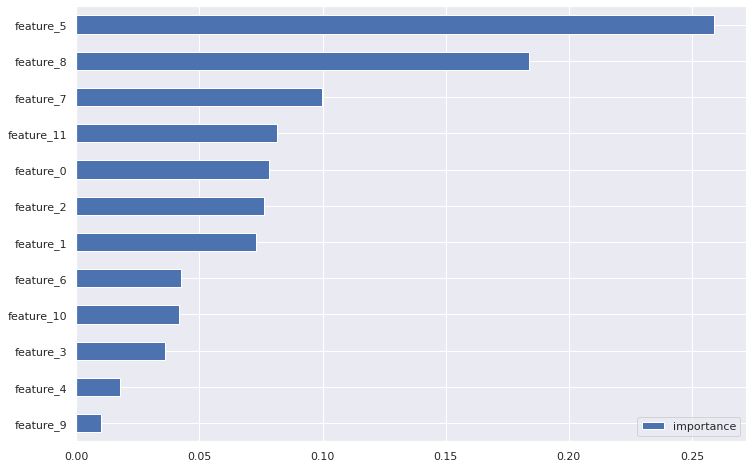

In [ ]:
imp = pd.DataFrame(gs_cv_clf.best_estimator_.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

Выведем вес фичей в табличном виде.

In [ ]:
best_clf = gs_cv_clf.best_estimator_
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train), 'feature_importances': feature_importances})
fi_df_sort = feature_importances_df.sort_values('feature_importances', ascending = False)
fi_df_sort

,features,feature_importances
5,feature_5,0.259006
8,feature_8,0.183943
7,feature_7,0.099726
11,feature_11,0.081622
0,feature_0,0.078216
2,feature_2,0.076147
1,feature_1,0.073098
6,feature_6,0.042344
10,feature_10,0.041721
3,feature_3,0.036190


Посчитаем метрику f-score и точность

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, gs_cv_clf.best_estimator_.predict(X_test))

0.47863247863247865

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, gs_cv_clf.best_estimator_.predict(X_test))

0.8445859872611465

In [ ]:
from joblib import dump, load
dump(best_clf, 'best_clf_RF.joblib') 

['best_clf_RF.joblib']

--------------------------------------------------------------------------------

Попробуем обучить модель нейросети для бинарной классификации. Загрузим библиотеки

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np

Создадим архитектуру модели. В общем-то задаём 3 слоя, наугад ставим кол-во ядер в каждом слое. Задаём входную форму, выходной канал = 1. Выбираем функции активации. Между слоями нейронов вставляем слои нормализации значений.

In [ ]:
tf.keras.utils.set_random_seed(13)
model = Sequential()
model.add(Dense(128, input_shape=(12,), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1664      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,753
Trainable params: 10,369
Non-traina

Компилируем модель, выбираем оптимизатор, скорость сходимости алгоритма, критерий сходимости - бинарная кроссэнтропия. Выводимая метрика - бинарная точность.

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['binary_accuracy'])

Фитим данные в модель. Разбиваем данные на порции, задаём кол-во иттераций обучения и кол-во данных под валидацию во время обучения. Обучаем.

In [ ]:
model.fit(X_train, y_train, batch_size=64, epochs=50, validation_split=0.2)

Epoch 1/50
89/89 [==============================] - 2s 6ms/step - loss: 0.5722 - binary_accuracy: 0.7225 - val_loss: 0.4947 - val_binary_accuracy: 0.8167
Epoch 2/50
89/89 [==============================] - 0s 3ms/step - loss: 0.4016 - binary_accuracy: 0.8366 - val_loss: 0.4454 - val_binary_accuracy: 0.8167
Epoch 3/50
89/89 [==============================] - 0s 4ms/step - loss: 0.3509 - binary_accuracy: 0.8572 - val_loss: 0.4350 - val_binary_accuracy: 0.8167
Epoch 4/50
89/89 [==============================] - 0s 3ms/step - loss: 0.3398 - binary_accuracy: 0.8582 - val_loss: 0.3924 - val_binary_accuracy: 0.8316
Epoch 5/50
89/89 [==============================] - 0s 4ms/step - loss: 0.3278 - binary_accuracy: 0.8627 - val_loss: 0.3861 - val_binary_accuracy: 0.8450
Epoch 6/50
89/89 [==============================] - 0s 3ms/step - loss: 0.3265 - binary_accuracy: 0.8665 - val_loss: 0.3838 - val_binary_accuracy: 0.8436
Epoch 7/50
89/89 [==============================] - 0s 4ms/step - loss: 0.31

Проводим оценку модели на тестовых данных. Бинарная точность 0.8, значение потерь: 0.64

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=64)
print('test loss, test acc:', results)

37/37 [==============================] - 0s 2ms/step - loss: 0.5302 - binary_accuracy: 0.8085
test loss, test acc: [0.5302287936210632, 0.8084925413131714]


In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')


К сожалению из модели нейросети довольно тяжело вытащить ценность признаков, поэтому ограничимся оценкой точности.

--------------------------------------------------------------------------------

Попробуем две модели бустинга.

Бустинг AdaBoost. Импортируем классификатор, задаём параметры. Импортируем сетку подбора лучших параметров, заполняем сетку. Выводим точность и лучшие параметры из сетки посел обучения.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
classifier_AdaBoost = AdaBoostClassifier(learning_rate=0.01, random_state=32)
classifier_AdaBoost.fit(X_train, y_train)
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators': [50,100,200,300,500]}] 
grid_search = GridSearchCV(estimator = classifier_AdaBoost,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Accuracy: ',best_accuracy,end='\n')
print('Best Parameters: ',best_parameters,end='\n')

Accuracy:  0.8364735886781716
Best Parameters:  {'n_estimators': 500}


Выводим вес фич графиком, в табличном виде.

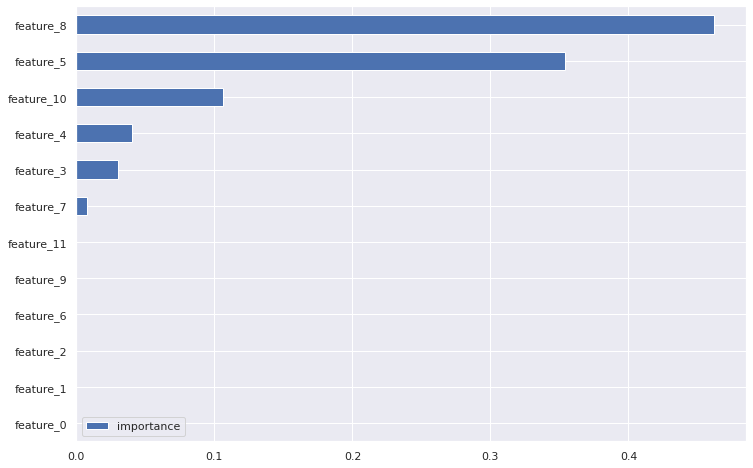

In [ ]:
imp = pd.DataFrame(grid_search.best_estimator_.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [ ]:
best_boost_clf = grid_search.best_estimator_
feature_importances = best_boost_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train), 'feature_importances': feature_importances})
fi_df_sort = feature_importances_df.sort_values('feature_importances', ascending = False)
fi_df_sort

,features,feature_importances
8,feature_8,0.462
5,feature_5,0.354
10,feature_10,0.106
4,feature_4,0.040
3,feature_3,0.030
7,feature_7,0.008
0,feature_0,0.000
1,feature_1,0.000
2,feature_2,0.000
6,feature_6,0.000


Выводим f1-score и точность модели на тестовых данных.

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, best_boost_clf.predict(X_test))

0.23465703971119134

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, best_boost_clf.predict(X_test))

0.8199575371549894

In [ ]:
dump(best_boost_clf, 'best_clf_AB.joblib')

['best_clf_AB.joblib']

----------------------------------------------------------------------------------------

Попробуем градиентный бустинг. Делаем то же самое, что с Ada. Выводим ценность фич, f-меру, точность.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
classifiergb = GradientBoostingClassifier(learning_rate=0.01,random_state=13)
classifiergb.fit(X_train, y_train)

parameters_gb = [{'n_estimators': [50,100,200,300,500]}] 
grid_search_gb = GridSearchCV(estimator = classifiergb,
                           param_grid = parameters_gb,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search_gb = grid_search_gb.fit(X_train, y_train)


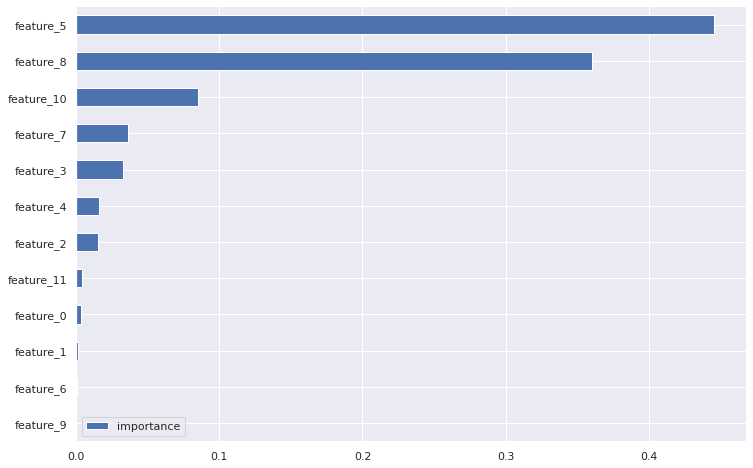

In [ ]:
best_clf_GB = grid_search_gb.best_estimator_
imp = pd.DataFrame(grid_search_gb.best_estimator_.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [ ]:
feature_importances = grid_search_gb.best_estimator_.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train), 'feature_importances': feature_importances})
fi_df_sort = feature_importances_df.sort_values('feature_importances', ascending = False)
fi_df_sort

,features,feature_importances
5,feature_5,0.445717
8,feature_8,0.360759
10,feature_10,0.085105
7,feature_7,0.036170
3,feature_3,0.032648
4,feature_4,0.015745
2,feature_2,0.014836
11,feature_11,0.003926
0,feature_0,0.002923
1,feature_1,0.001425


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, classifiergb.predict(X_test))

0.3005181347150259

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, classifiergb.predict(X_test))

0.8280254777070064

In [ ]:
dump(best_clf_GB, 'best_clf_GB.joblib')

['best_clf_GB.joblib']

-------------------------------------------------------------------------------------

Пропустим данные через Логистическую регрессию. Выберем сольвер, рандомное значение. Остальные параметры оставим по умолчанию.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression(solver='liblinear', random_state=12)

In [ ]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=12, solver='liblinear')

In [ ]:
y_pred_test = logreg.predict(X_test)
y_pred_test

array([0., 0., 0., ..., 0., 0., 0.])

Выведем метрики.

In [ ]:
f1_score(y_test, logreg.predict(X_test))

0.37538461538461537

In [ ]:
accuracy_score(y_test, y_pred_test)

0.8276008492569003

In [ ]:
dump(logreg, 'logreg.joblib')

['logreg.joblib']

Выведем коэффициенты модели. Наиболее ценный коэффициент - пятый.

------------------------------------------------------------------------------------

In [ ]:
print(logreg.coef_)

[[ 0.02930636 -0.10259392 -0.38280861  0.18608871 -0.53335348  4.59103048
  -0.11007719  0.57591419 -0.55075825 -0.01867341 -0.86148456  0.0879825 ]]


Попробуем дерево решений для выполнения нашей задачи. Зададим параметры для сетки, обучим, выведем лучшие параметры, ценность фичей и метрики.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf_tree = DecisionTreeClassifier(random_state=19)
parametrs = {'criterion': ['entropy'], 'max_depth': range(1, 13, 2), 'min_samples_split': range(2, 10, 2), 'min_samples_leaf': range(1, 8)}

In [ ]:
gs_clf_tree = GridSearchCV(clf_tree, parametrs, cv=5, n_jobs=-1)
gs_clf_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=19), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2)})

In [ ]:
gs_clf_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 6,
 'min_samples_split': 2}

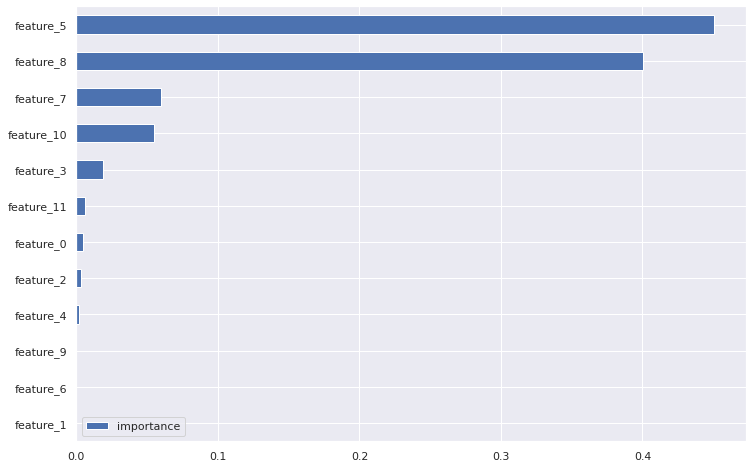

In [ ]:
imp = pd.DataFrame(gs_clf_tree.best_estimator_.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [ ]:
best_clf = gs_clf_tree.best_estimator_
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train), 'feature_importances': feature_importances})
fi_df_sort = feature_importances_df.sort_values('feature_importances', ascending = False)
fi_df_sort

,features,feature_importances
5,feature_5,0.450550
8,feature_8,0.400340
7,feature_7,0.059675
10,feature_10,0.054596
3,feature_3,0.018523
11,feature_11,0.006043
0,feature_0,0.004738
2,feature_2,0.003626
4,feature_4,0.001908
1,feature_1,0.000000


In [ ]:
f1_score(y_test, gs_clf_tree.best_estimator_.predict(X_test))

0.4658298465829847

In [ ]:
accuracy_score(y_test, gs_clf_tree.best_estimator_.predict(X_test))

0.8373673036093419

In [ ]:
dump(best_clf, 'best_clf_DT.joblib')

['best_clf_DT.joblib']

---------------------------------------------------------------------------------

Выводы:

Рандом форест: 5, 8, 7 фичи. 0.47/0.84 f1-score/точность


Дерево решений: 5, 8 фичи. 0.46/0.83 f1-score/точность


АдаБуст: 8, 5, 10 фичи. 0.23/0.82 f1-score/точность


ГрадиентБуст: 5, 8, 10 фичи. 0.3/0.82 f1-score/точность


Нейронная сеть: точноть 0.807

Логистическая регрессия: 5 фича. 0.37/0.82

Лучший алогритм: РандомФорест.
Самые ценные признаки: 5, 8, 7, 10